In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/juanhuang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/juanhuang/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juanhuang/nltk_data...


True

In [3]:
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

In [4]:
# check for the balance of data
len(df_true),len(df_fake)

(21417, 23481)

In [5]:
# label the true news as 0 and fake news as 1
df_true['label'] = [0]*len(df_true)
df_fake['label'] = [1]*len(df_fake)
df = pd.concat([df_true,df_fake])

# take 10% random sample from the pupulation and split the sample into training and test dataset
subsample_x,_,subsample_y,_ = train_test_split(df[df.columns[:-1]],df[df.columns[-1]],test_size = 0.9,random_state = 42)
x_train,x_test,y_train,y_test = train_test_split(subsample_x,subsample_y,test_size = 0.2,random_state = 42)

In [6]:
def preprocessing(df,label):
    df['label'] = label.values
    # add features of length of title and length of text
    df['title_L'] = df['title'].apply(lambda x : len(x))
    df['text_L'] = df['text'].apply(lambda x : len(x))

    # delete data with empty string or string with size one.
    df = df[(df.title_L>1)& (df.text_L>1)]

    # one hot encoding the subject
    one_hot  = pd.get_dummies(df['subject'])
    df = df.join(one_hot)

    # count the number of adjective words in text as fake news may deliberately 
    # contain more details to make it more real.
    def num_JJ(sent):
        count = 0 
        sent = nltk.word_tokenize(sent.translate(dict.fromkeys(string.punctuation)))
        sent = nltk.pos_tag(sent)
        for i in sent:
              if i[1] == 'JJ':
                count+=1
        return count
    df['num_JJ'] = df['text'].apply(num_JJ)
    
    # calculate the sentimental score of the news as fake news tend to be emotional than true news.
    def sentiment_score(sent):
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(sent)
        return ss['compound']
    df['sentiment_score'] = df['text'].apply(sentiment_score)
    return df



In [7]:
import warnings
warnings.filterwarnings('ignore')
df_train = preprocessing(x_train,y_train)
df_test = preprocessing(x_test,y_test)

In [12]:
len(df_train),len(df_test)

(3828, 903)

In [8]:
col = df_train.columns
col

Index(['title', 'text', 'subject', 'date', 'label', 'title_L', 'text_L',
       'Government News', 'Middle-east', 'News', 'US_News', 'left-news',
       'politics', 'politicsNews', 'worldnews', 'num_JJ', 'sentiment_score'],
      dtype='object')

In [10]:
xgb = XGBClassifier(eta = 0.1,min_child_weight=10,subsample = 0.6,n_estimators = 100,objective ='binary:logistic' )
# use col[5:] as features and col[4] label as y 
x_train,y_train = df_train[col[5:]],df_train[col[4]]
x_test,y_test = df_test[col[5:]],df_test[col[4]]

xgb.fit(x_train,y_train)

predictions = xgb.predict(x_test)

# calculate f1 score 
f1 = f1_score(y_test,predictions)
f1

[22:58:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.979020979020979

<BarContainer object of 12 artists>

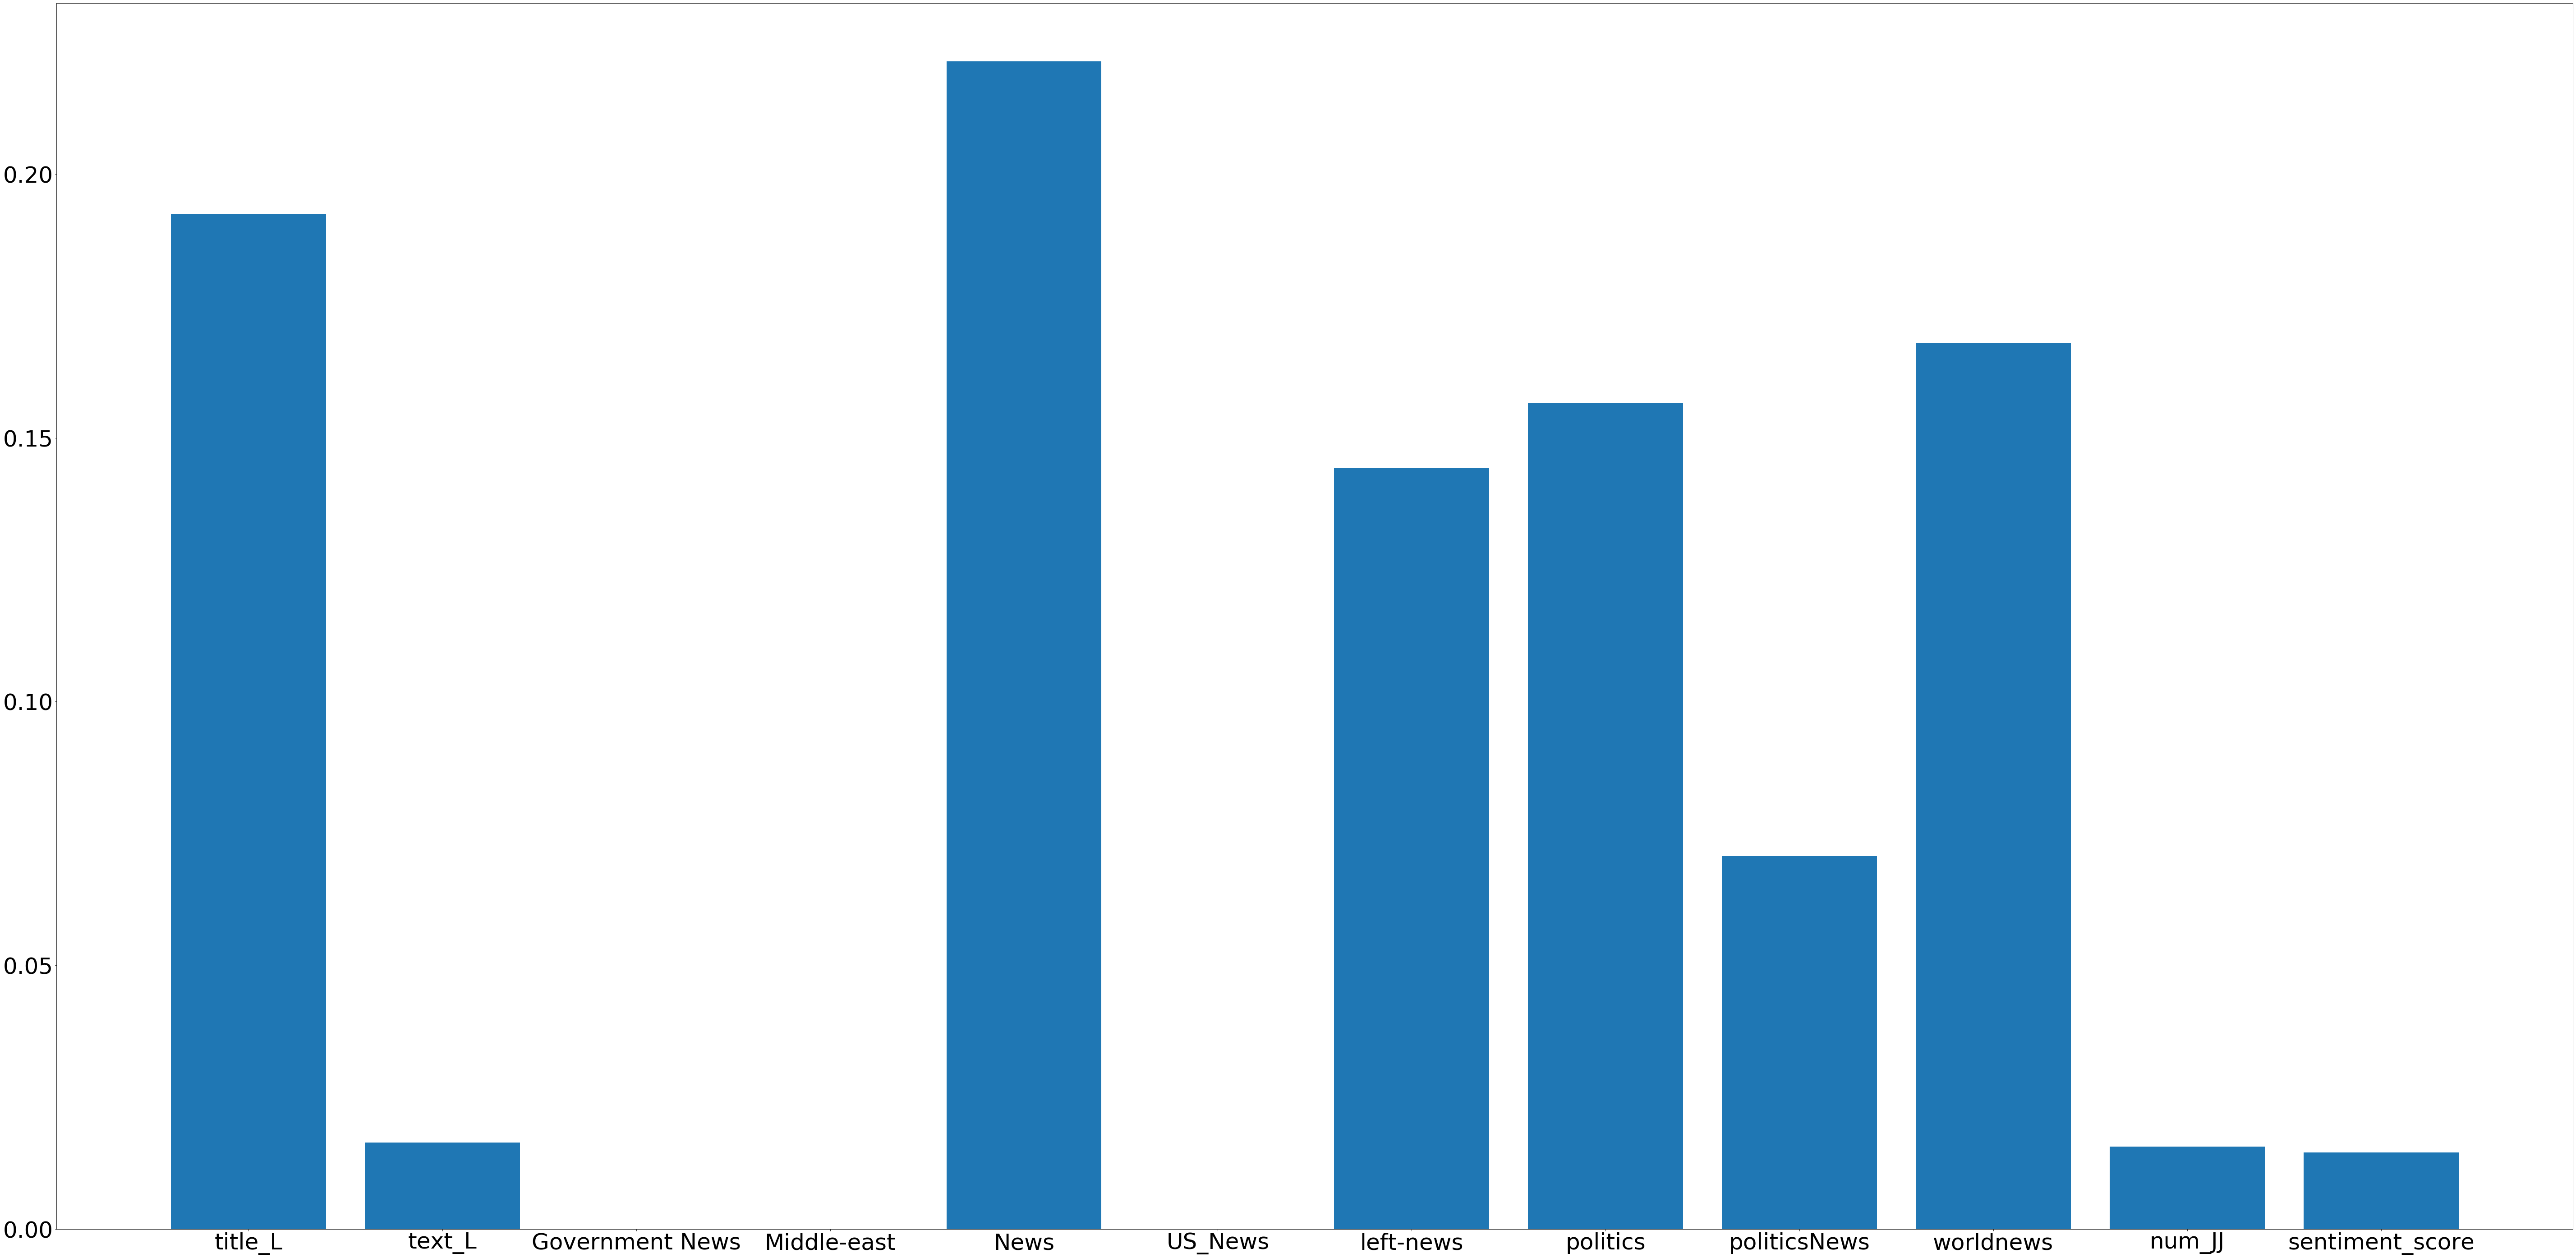

In [11]:
# plot feature importance of each feature
plt.rcParams.update({'font.size': 50})
plt.figure(figsize= (100,50))
plt.bar(list(col[5:]),xgb.feature_importances_)